# MINIPROJECT 1

## Classification, weight sharing, auxiliary losses


The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective.

### 0. Import libraries

In [1]:
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F

from dlc_practical_prologue import generate_pair_sets

### 1. Generate data

In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

def normalize_data(train_input, test_input):
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)
    
def to_one_hot(tensor):
    one_hot = torch.zeros((tensor.size(0), 10)).type(torch.FloatTensor)
    one_hot[list(range(0,tensor.size(0))), tensor[:,0]] = 1
    return one_hot

train_input = train_input.reshape((train_input.size(0)*2, 1, train_input.size(2), train_input.size(3)))
train_classes_r = train_classes.reshape((train_classes.size(0)*2, 1))
test_input = test_input.reshape((test_input.size(0)*2, 1, test_input.size(2), test_input.size(3)))
test_classes_r = test_classes.reshape((test_classes.size(0)*2, 1))

train_classes_one_hot = to_one_hot(train_classes_r)
test_classes_one_hot = to_one_hot(test_classes_r)

#train_target = train_target.type(torch.FloatTensor)
#test_target = test_target.type(torch.FloatTensor)

train_target_bin = torch.zeros((train_target.size(0), 2))
train_target_bin[list(range(train_target.size(0))), train_target[:]] = 1

test_target_bin = torch.zeros((test_target.size(0), 2))
test_target_bin[list(range(test_target.size(0))), test_target[:]] = 1

normalize_data(train_input, test_input)

In [3]:
import random
import matplotlib.pyplot as plt

tensor([4, 2])
Target: 0
tensor([1, 1])
Target: 1
tensor([8, 7])
Target: 0
tensor([3, 3])
Target: 1


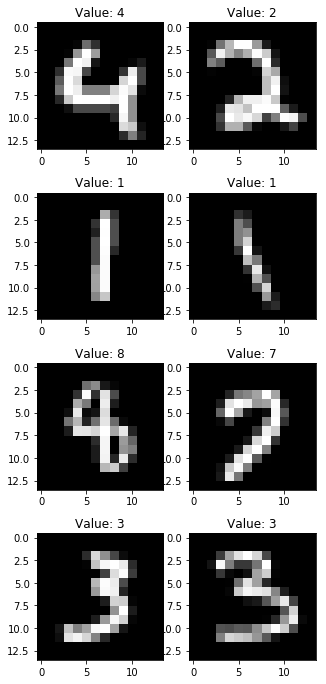

In [4]:
fig, ax = plt.subplots(4, 2, figsize=(5,12))
ax = ax.flatten()
for i in range(4):
    r = int(1000*random.random())
    test_i, test_c, test_t = train_input[r*2:r*2+2], train_classes[r], train_target[r]
    print(test_c)
    print('Target: {}'.format(test_t.item()) )
    
    ax[i*2].imshow(test_i[0][0], cmap="gray")
    ax[i*2].set_title('Value: {}'.format(test_c[0].item()))
    ax[i*2+1].imshow(test_i[1][0], cmap="gray")
    ax[i*2+1].set_title('Value: {}'.format(test_c[1].item()))
plt.show()



### 2. Define train function and other auxiliary functions that can be necessary


In [18]:
# Define training function for convolutional model
def train_model_conv(model, train_input, train_target, epochs=25, \
                mini_batch_size=200, lr=1e-3, criterion=None, optimizer=None, verbose=2):
    
    print('Training Conv Net')
    
    # use MSE loss by default
    if not criterion:
        criterion = nn.MSELoss()
        
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)

    
    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            optimizer.step()
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
            

# Define training for fully connected model
def train_model_fc(model, train_input, train_target, epochs=25, \
                mini_batch_size=200, lr=1e-3, criterion=None, optimizer=None, verbose=2):
    print('Training Fully connected net')
    
    # use MSE loss by default
    if not criterion:
        criterion = nn.MSELoss()
        
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)

    
    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward(retain_graph=True)
            sum_loss = sum_loss + loss.item()
            optimizer.step()
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
            

# Define model for composed model            
def train_model_all(model, train_input, train_classes, train_target, epochs=25, \
                mini_batch_size=100, lr=1e-3, criterion1=None, criterion2=None, optimizer=None, verbose=2):
    
    print('Training Composed model')
    
    # use MSE loss by default
    if not criterion1:
        criterion1 = nn.MSELoss()
    if not criterion2:
        criterion2 = nn.MSELoss()
        
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)

    
    for e in range(epochs):
        sum_loss = 0
        
        for b in range(0, train_target.size(0), mini_batch_size):
            output_classes, output_final = model(train_input.narrow(0, b*2, mini_batch_size*2))
            loss1 = criterion1(output_classes, train_classes.narrow(0, b*2, mini_batch_size*2))
            loss2 = criterion2(output_final, train_target.narrow(0, b, mini_batch_size))
            loss = loss1 + loss2
            model.zero_grad()
            loss.backward(retain_graph=True)
            sum_loss = sum_loss + loss.item()
            optimizer.step()
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
    
            


def compute_nb_errors(model, input, target, mini_batch_size=100):
    errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        for k in range(mini_batch_size):
            if target.data[b + k, predicted_classes[k]] <= 0:
                errors = errors + 1
    return errors


    


In [6]:

class Net_Conv(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x    
    

class Net_Full(nn.Module):
    def __init__(self):
        super(Net_Full, self).__init__()
        self.fc1 = nn.Linear(20, 100)
        self.fc2 = nn.Linear(100,200)
        self.fc3 = nn.Linear(200, 2)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_All(nn.Module):
    def __init__(self, nb_h1, nb_h2, nb_h4, nb_h5):
        super(Net_All, self).__init__()
        self.conv1 = nn.Conv2d(1,nb_h1, kernel_size=5)
        self.conv2 = nn.Conv2d(nb_h1, nb_h2, kernel_size=3)
        self.conv3 = nn.Conv2d(nb_h2, 32, kernel_size=1)
        self.fc1 = nn.Linear(32*6*6, nb_h4)
        self.fc2 = nn.Linear(nb_h4, 10)
        self.fc3 = nn.Linear(20, nb_h5)
        self.fc4 = nn.Linear(nb_h5,2)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=1))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, (32*6*6))))
        x_classes = F.relu(self.fc2(x))
        x_out = F.relu(self.fc3(x_classes.view(-1, 20)))
        x_out = self.fc4(x_out)
        return x_classes, x_out

### 3. Generate MLP 1 - with aux loss


In [7]:
train_input, train_target_bin, train_classes_one_hot = Variable(train_input), Variable(train_target_bin), Variable(train_classes_one_hot)
test_input, test_target_bin, test_classes_one_hot = Variable(test_input), Variable(test_target_bin), Variable(test_classes_one_hot)
print(train_input.shape, train_target_bin.shape, train_classes_one_hot.shape)
print(test_input.shape, test_target_bin.shape, test_classes_one_hot.shape)

torch.Size([2000, 1, 14, 14]) torch.Size([1000, 2]) torch.Size([2000, 10])
torch.Size([2000, 1, 14, 14]) torch.Size([1000, 2]) torch.Size([2000, 10])


In [24]:
nb_error_test = []
for k in range(10):
    model1 = Net_Conv(200)
    model2 = Net_Full()
    train_model_conv(model1, train_input, train_classes_one_hot, lr=1, verbose=2)
    train_model_fc(model2, train_classes_one_hot.view(1000,20), train_target_bin, lr=5e-1, verbose=2)
    
    out = model2(model1(test_input).view(1000, 20))
    _, argm = out.max(1)
    nb_test_errors = 1000 - (argm == test_target).sum(0)
    nb_error_test.append(100.0*nb_test_errors/test_target.size(0))
    
    #nb_test_errors_n1 = compute_nb_errors(model1, test_input, test_classes_one_hot)
    #nb_error_test += nb_test_errors_n1
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_target.size(0),
                                                      nb_test_errors, test_target.size(0)))

print('Test error mu: {:0.2f}% '.format(sum(nb_error_test)/len(nb_error_test)))


Training Conv Net
Training Fully connected net
test error Net 7.00% 72/1000
Training Conv Net
Training Fully connected net
test error Net 7.00% 70/1000
Training Conv Net
Training Fully connected net
test error Net 8.00% 85/1000
Training Conv Net
Training Fully connected net
test error Net 7.00% 70/1000
Training Conv Net
Training Fully connected net
test error Net 7.00% 78/1000
Training Conv Net
Training Fully connected net
test error Net 7.00% 79/1000
Training Conv Net
Training Fully connected net
test error Net 6.00% 68/1000
Training Conv Net
Training Fully connected net
test error Net 6.00% 62/1000
Training Conv Net
Training Fully connected net
test error Net 7.00% 77/1000
Training Conv Net
Training Fully connected net
test error Net 8.00% 87/1000
Test error mu: 7.00% 


## IMPORTANT::

THERE IS SOMETHING WRONG AS THE OUTPUT TARGET DOES NOT MATCH THE REALITY!!! (CHECK VISUALIZATION PART)
CHECK HOW TO ITERATE OVER TARGET AND INPUTS AS DIMENSIONS ARE NOT THE SAME!!!

-- UPDATE (7.04.19 - ) seems to be fixed although target and classes do not always make sense (saying 3 > 9) in the test set

In [20]:
nb_error_test = []
for k in range(10):
    model = Net_All(32, 64, 50, 100)
    train_model_all(model, train_input, train_classes_one_hot, train_target_bin, lr=0.5)
    
    out_class, out_target = model(test_input)
    _, argmax_class = out_class.max(1)
    _, argmax_target = out_target.max(1)
    nb_test_errors = 1000 - (argmax_target == test_target).sum(0)
    nb_error_test.append(100.0*nb_test_errors/test_target.size(0))
    
    #nb_test_errors_n1 = compute_nb_errors(model1, test_input, test_classes_one_hot)
    #nb_error_test += nb_test_errors_n1
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_target.size(0),
                                                      nb_test_errors, test_target.size(0)))

print('Test error mu: {:0.2f}% '.format(sum(nb_error_test)/len(nb_error_test)))

Training Composed model
test error Net 10.00% 109/1000
Training Composed model
test error Net 9.00% 98/1000
Training Composed model
test error Net 12.00% 127/1000
Training Composed model
test error Net 9.00% 91/1000
Training Composed model
test error Net 8.00% 86/1000
Training Composed model
test error Net 11.00% 112/1000
Training Composed model
test error Net 8.00% 85/1000
Training Composed model
test error Net 11.00% 114/1000
Training Composed model
test error Net 10.00% 109/1000
Training Composed model
test error Net 9.00% 93/1000
Test error mu: 9.00% 


## Visualize results

Target: 1, Output : 1
Target: 1, Output : 1
Target: 1, Output : 1
Target: 0, Output : 0


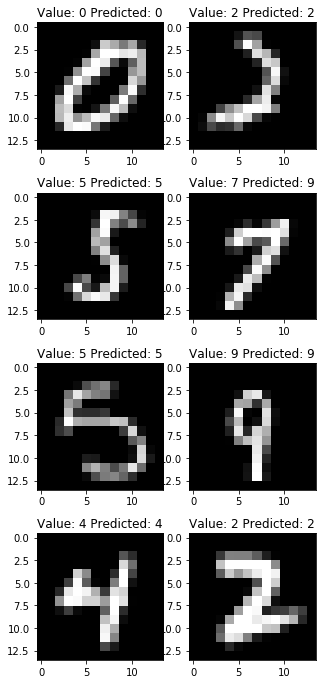

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(5,12))
ax = ax.flatten()
for i in range(4):
    r = int(1000*random.random())
    test_i, test_c, test_t = test_input[r*2:r*2+2], test_classes[r], test_target[r]
    out_c, out_t = model(test_i)
    _, pred_c = out_c.max(1)
    _, pred = out_t.max(1)
    print('Target: {}, Output : {}'.format(test_t.item(), pred.item()) )
    
    ax[i*2].imshow(test_i[0][0], cmap="gray")
    ax[i*2].set_title('Value: {} Predicted: {}'.format(test_c[0].item(), pred_c[0].item()))
    ax[i*2+1].imshow(test_i[1][0], cmap="gray")
    ax[i*2+1].set_title('Value: {} Predicted: {}'.format(test_c[1].item(), pred_c[1].item()))
plt.show()


### 4. Generate ConvNet 1 - with aux loss 

### 5. Generate MLP 2 - without aux loss

### 6. Generate ConvNet 2 - without aux loss 

In [11]:
### 7. Generate 